In [51]:
import pandas as pd
import numpy as np
import pymc3 as pm
import pandas as pd
import numpy as np
import scipy.stats
from scipy.stats import skew, kurtosis, norm
import math
from yahoo_fin.stock_info import get_data
import seaborn as sns
import matplotlib.pyplot as plt
import arviz as az

In [31]:
# Fund price data - not NAV
tickers = ['PGHN.SW', 'VDIGX', 'VQNPX']
hist_prices = {}

for ticker in tickers:
    hist_prices[ticker] = get_data(ticker, start_date='01/01/2015', interval='1mo')

PG = hist_prices['PGHN.SW']
VDIGX = hist_prices['VDIGX']
VQNPX = hist_prices['VQNPX']

In [32]:
# Compute returns - 1.) log 2.) Adj. log 3.) demean return
def returns(ticker):
    
    ticker['Adj Log Return'] = np.log(ticker['adjclose']).diff()
    ticker.index = pd.to_datetime(ticker.index)
    return ticker

VQNPX = returns(VQNPX)
PG = returns(PG)

/Users/gabestechschulte/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


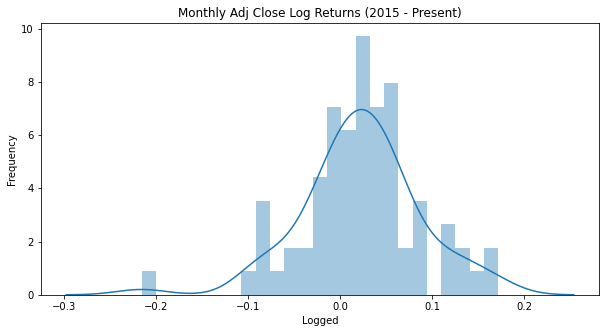

In [35]:
def distribution(ticker, date):
    
    plt.figure(figsize=(10,5))
    sns.distplot(ticker['Adj Log Return'], kde=True, bins=25)
    plt.title('Monthly Adj Close Log Returns ({} - Present)'.format(date))
    plt.xlabel('Logged')
    plt.ylabel('Frequency')
    
distribution(PG, '2015')

In [36]:
def descriptive_stats(ticker):
   
    print(skew(ticker['Adj Log Return']))
    print(kurtosis(ticker['Adj Log Return']))
    print("Average monthly return = ", round(ticker['Adj Log Return'].mean(), 4))

descriptive_stats(PG)

nan
nan
Average monthly return =  0.0221


In [37]:
# Just curious to see the probability of monthly returns, on average, for the sample
def cdf(ticker):
    
    mu = np.mean(ticker['Adj Log Return'])
    std = np.std(ticker['Adj Log Return'])
    
    #Probability of having a good average monthly return: Pr(mu > #.#%)
    good_return = 1-(scipy.stats.norm.cdf(0.006, mu, std))
    print('The probability of having a good monthly return: Pr(mu > 0.6%) = ', round(good_return,2))

    neg_return = scipy.stats.norm.cdf(0.0, mu, std)
    print('The probability of having a negative monthly return: Pr(mu < 0.0%) = ', round(neg_return,2))
    
cdf(PG)

The probability of having a good monthly return: Pr(mu > 0.6%) =  0.6
The probability of having a negative monthly return: Pr(mu < 0.0%) =  0.36


# **The four-step process in Bayesian analysis consists of:**

1. Modeling: Model parameters of interest as random variables, specify prior (density) functions and likelihood.
2. Updating: Update posterior (density) functions of parameters using data, priors, and likelihood.
3. Sampling: Generate samples from posterior (density) functions.
4. Inference: Summarize on parameters from posteriors samples using point or interval estimates

In [19]:
# The prior parameter inputs domain knowledge into prior probabilities
# I.e, Fund manager belief of negative average returns (and higher volatility)
def prior_params(ticker, mu, std):
    
    prior_params = {ticker: (mu, std)}
    
    return prior_params

prior_PG = prior_params('PG', 0.02, 0.075)

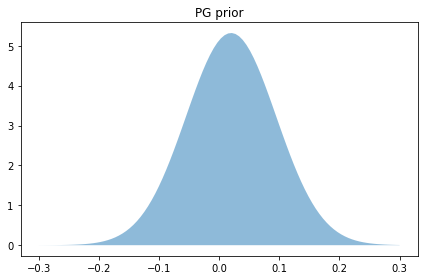

In [27]:
# Make this dynamic
x = np.linspace(-0.3, 0.3, 100)

for i, (name, params) in enumerate(prior_PG.items()):
    
    y = norm.pdf(x, params[0], scale=params[1])
    plt.fill_between(x, 0, y, linewidth=2, alpha=0.5)
    plt.title(name + ' prior')
    #plt.xlim(-0.25, 0.25)
    plt.tight_layout()
    

In [9]:
def preprocessing(ticker):
    
    values = ticker['Adj Log Return'].values
    #demeaned = values - values.mean()
    return values
    
PG_returns = preprocessing(PG)

In [10]:
# Put this in the function above 
PG_returns = PG_returns[np.logical_not(np.isnan(PG_returns))] 

# Model Specification

In [39]:
# Obtaining my prior(s) and putting them in a list
def priors(params):
    
    prior_mu = np.array([x[0] for x in params.values()]) 
    prior_std = np.array([x[1] for x in params.values()])
    
    return prior_mu, prior_std

prior_PG_mu, prior_PG_std = priors(prior_PG)

In [46]:
# Model object is a container for the model's random variables (parameters of interest)
# This model does not include our prior observations 
model = pm.Model()

with model:
    
    # Priors for unknown model parameters
    mu = pm.Normal("mu", mu=0.0, sigma=0.01)
    tau = pm.Gamma("tau", mu=0.001, sigma=0.001)
    sigma = 1 / np.sqrt(tau)
    
    # Likelihood f(D|Θ)
    # Sampling distribution of observations
    # The mu and sigma should be unknown and not fixed values 
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=PG_returns)
    

# Model Fitting

 - Having specified our model, the next step is to obtain posterior estimates for the unknown variables in the model
 - Finding the MAP point and computing summaries based on samples drawn from the posterior distribution using MCMC sampling 

In [45]:
# Finding the MAP point for the original model
map_estimate = pm.find_MAP(model=model)
map_estimate

{'mu': array(1.52680631e-05),
 'tau_log__': array(-2.71084225),
 'tau': array(0.06648079)}

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tau, mu]


Sampling 2 chains for 2_000 tune and 1_000 draw iterations (4_000 + 2_000 draws total) took 18 seconds.


array([[<AxesSubplot:title={'center':'mu'}>,
        <AxesSubplot:title={'center':'mu'}>],
       [<AxesSubplot:title={'center':'tau'}>,
        <AxesSubplot:title={'center':'tau'}>]], dtype=object)

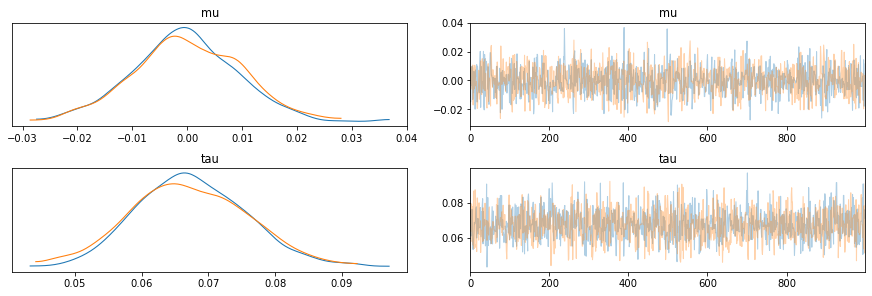

In [55]:
# Sampling from posterior distribution - the parameter(s) of interest
with model:
    trace = pm.sample(1000, tune=2000, return_inferencedata=True)
az.plot_trace(trace)